<img align="right" src="https://www.python.org/static/community_logos/python-logo-master-v3-TM.png" style="height: 100px; width:300px;"/>
<img align="left" src="../theme/mowgli_logo.png" style="height: 150px; width:200px;"/>

# <h3 align="center">**Notebook Random Forest - Projet Mowgli**</h3> 

 Ce notebook a pour but de montrer **l'implémentation du modèle Random Forest** et des principaux paramètres à tuner afin d'améliorer les performances du modèle.

 <div class="alert alert-block alert-danger">
    Dans ce notebook, l'attention est portée sur le modèle de Random Forest. <b>La démarche d'évaluation du modèle est loin d'être parfaite et sera traitée dans un autre notebook</b>.
</div>

In [1]:
# Base
from pathlib import Path

# Preprocessing
import numpy as np
import pandas as pd

# Modelling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

## **1. Preprocessing**

### **1.1. Chargement des données**

**Données : Base de consommation électrique - MA**

In [2]:
PROJECT_PATH = Path("/dataspacefull_share/transverse/Mowgli/dev/")

In [3]:
data_reg = pd.read_csv(
    PROJECT_PATH / "data" / "base_regression1.csv", sep=";", decimal=","
)

In [4]:
numerical_cols = [
    "NB_ANNEE_CREATION_ET",
    "NB_ANNEE_CREATION_EN",
    "SIREN_NB_SIRET",
    "SIRET_TRANCHE_EFFECTIF_CONSOLIDE",
    "SIREN_TRANCHE_EFFECTIF_CONSOLIDE",
    "DEPT_SECT_CONSOMMATION_MWH",
    "NOMBRE_BATI",
    "SURFACE_AU_SOL_TOTALE",
    "SURFACE_PLANCHER_TOTALE",
    "SURFACE_AU_SOL_PONDEREE",
    "SURFACE_PLANCHER_PONDEREE",
    "SCORE_IGN",
    "NBRE_SIRET_ADR",
    "latitude",
    "longitude",
    "DEPT_DJU",
    "ZONE_URBAINE",
]
categorical_cols = [
    "SIEGE",
    "BRANCHE",
    "SOUS_BRANCHE",
    "SIREN_CA_SUP_1MILLION_EUR",
    "ZONE_CLIMATIQUE",
]
other_cols = ["SIRET", "SIRET_CONSOMMATIONMWH_ANNUELLE"]
# unused_cols = ['Unnamed: 0', 'SIREN', 'LIBAPET', 'NJ', 'L4_NORMALISEE', 'L6_NORMALISEE', 'DEPET', 'NAF_SECT_ET', 'NJ1', 'SIREN_RISQUE', 'NIV1NAF', 'NIV2NAF', 'FLAG_BRANCHE_TERTIAIRE', \
#                'APET700', 'SOUS_BRANCHE']
unused_cols = [
    "SIREN",
    "NAF_SECT_ET",
    "NJ1",
    "SIREN_RISQUE",
    "NIV1NAF",
    "NIV2NAF",
    "FLAG_BRANCHE_TERTIAIRE",
    "APET700",
]

data_reg = data_reg[data_reg.SURFACE_PLANCHER_PONDEREE != 0]
data_reg = data_reg[data_reg.SURFACE_AU_SOL_PONDEREE != 0]
data_reg = data_reg[data_reg.SIRET_CONSOMMATIONMWH_ANNUELLE > 0]

In [5]:
data_reg = data_reg.astype(
    {
        "NB_ANNEE_CREATION_ET": "float64",
        "NB_ANNEE_CREATION_EN": "float64",
        "DEPT_SECT_CONSOMMATION_MWH": "float64",
    }
)
data_reg = data_reg[~data_reg["SIRET_CONSOMMATIONMWH_ANNUELLE"].isna()]
data_reg = data_reg[data_reg.FLAG_BRANCHE_TERTIAIRE == 1]


data_reg = data_reg[data_reg.SURFACE_PLANCHER_PONDEREE != 0]
data_reg = data_reg[data_reg.SURFACE_AU_SOL_PONDEREE != 0]
data_reg = data_reg[data_reg.SIRET_CONSOMMATIONMWH_ANNUELLE > 0]

In [6]:
# Surfaces to log(Surfaces)

data_reg["SURFACE_AU_SOL_PONDEREE"] = np.log10(data_reg["SURFACE_AU_SOL_PONDEREE"])
data_reg["SURFACE_PLANCHER_PONDEREE"] = np.log10(data_reg["SURFACE_PLANCHER_PONDEREE"])
data_reg["SURFACE_AU_SOL_TOTALE"] = np.log10(data_reg["SURFACE_AU_SOL_TOTALE"])
data_reg["SURFACE_PLANCHER_TOTALE"] = np.log10(data_reg["SURFACE_PLANCHER_TOTALE"])

# Conso to log(Conso)

data_reg["SIRET_CONSOMMATIONMWH_ANNUELLE"] = np.log10(
    data_reg["SIRET_CONSOMMATIONMWH_ANNUELLE"]
)

In [7]:
transfo = data_reg.copy(deep=True)
transfo.drop(unused_cols, axis=1, inplace=True)

### **1.2. Train/Test split**

In [8]:
train, test = train_test_split(transfo, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

### **1.3. Création du Pipeline de preprocessing**

In [9]:
# on définit les colonnes et les transformations pour les colonnes quantitatives
numerical_cols

transfo_quanti = Pipeline(
    steps=[
        # ('remove_outliers',OutlierRemover(factor=1.5)),
        ("imputation", SimpleImputer(strategy="median")),
        ("standard", StandardScaler()),
    ]
)

# on définit les colonnes et les transformations pour les variables qualitatives
categorical_cols

transfo_quali = Pipeline(
    steps=[
        # ('rare_values',RareValuesGrouper(threshold=0.05)),
        ("imputation", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# on définit l'objet de la classe ColumnTransformer qui va permettre d'appliquer toutes les étapes
preparation = ColumnTransformer(
    remainder="passthrough",
    transformers=[
        ("quanti", transfo_quanti, numerical_cols),
        ("quali", transfo_quali, categorical_cols),
    ],
)

In [10]:
# On fit-transforme le train
train_transformed = preparation.fit_transform(train)

# On transforme la validation
val_transformed = preparation.transform(val)

# On transforme le test
test_transformed = preparation.transform(test)

In [11]:
# On récupère les noms des colonnes onehot encodées
categorical_onehotenc_cols = (
    preparation.transformers_[1][1][1].get_feature_names_out().tolist()
)

# On transforme la matrice résultante de la transformation en dataframe
train_transformed = pd.DataFrame(
    train_transformed, columns=numerical_cols + categorical_onehotenc_cols + other_cols
)

val_transformed = pd.DataFrame(
    val_transformed, columns=numerical_cols + categorical_onehotenc_cols + other_cols
)

test_transformed = pd.DataFrame(
    test_transformed, columns=numerical_cols + categorical_onehotenc_cols + other_cols
)

In [12]:
feature_cols = [
    x
    for x in train_transformed.columns
    if x not in ["SIRET", "SIRET_CONSOMMATIONMWH_ANNUELLE"]
]

In [13]:
def get_dataset(df):
    X = df.loc[:, feature_cols]
    y = df["SIRET_CONSOMMATIONMWH_ANNUELLE"]
    return X, y

In [14]:
X_train, y_train = get_dataset(train_transformed)
X_val, y_val = get_dataset(val_transformed)
X_test, y_test = get_dataset(test_transformed)

## **2. Modélisation**

### **2.1. Définition du modèle du RandomForest**

L’algorithme des « forêts aléatoires » (ou « Random Forest ») permet de combiner un grand nombre d’arbres de décision où chaque arbre est entrainé sur des sous-ensembles de données différents selon une approche de type « bagging », c’est-à-dire par tirage aléatoire avec remise, et uniquement sur un sous ensemble de variables choisies de manière aléatoire. 

Cet algorithme est l’un des modèles les plus efficaces pour les données tabulaires et nécessite très peu de prétraitement de données. Il a permis d’améliorer significativement les performances de notre estimation de la consommation.

### **2.2. Implémentation du modèle**

Ici nous allons traiter une problématique de type régression, nous allons donc utiliser la classe issue de sklearn `RandomForestRegressor`.

Dans le cadre d'une classification, c'est la classe `RandomForestClassifier` qui devra être utilisée.

Dans un premier temps, nous allons implémenter **un modèle Random Forest simple**, en paramétrant uniquement le nombre d'arbres `n_estimators`. Le nombre d'arbres est le paramètre le plus important pour un modèle de Random Forest.
: 

In [15]:
from sklearn.ensemble import RandomForestRegressor

# from sklearn.ensemble import RandomForestClassifier # à utiliser dans le cadre d'une classification

In [16]:
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train);

In [17]:
y_train_predicted = rf.predict(X_train)
y_val_predicted = rf.predict(X_val)

#### **Importance des variables**

L'implémentation des Random Forest dans scikit-learn permet d'obtenir facilement l'importance des features. 
Par contre, la [méthode implémentée de calcul de l'importance des features](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_) donne souvent des résultats biaisés. <b>Des méthodes d'explicabilité plus robustes sont abordées dans le notebook d'explicabilité.

Pour plus d'informations sur les limites de la méthode de calcul d'importances implémentée par défaut dans scikit-learn: [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

<hr></hr>
L'importance des variables est normalisée, la somme de l'importance de toutes les colonnes est égale à 1.

In [18]:
rf.feature_importances_

array([9.52805309e-03, 9.28925732e-03, 5.20254418e-03, 7.56387239e-03,
       5.45733923e-03, 7.64987300e-03, 2.51688733e-03, 8.63281818e-03,
       8.16402560e-03, 8.75018570e-03, 7.87445251e-01, 1.94776779e-03,
       5.65143846e-03, 9.79292471e-03, 9.79933080e-03, 6.44589284e-03,
       6.28493283e-03, 4.71296719e-04, 4.99440540e-04, 3.65345212e-03,
       5.25254557e-03, 1.42590879e-02, 8.16186846e-04, 3.43182261e-04,
       4.77784023e-04, 2.62873798e-04, 1.56549250e-04, 2.57723126e-03,
       1.52020930e-03, 2.15450720e-02, 2.01315851e-03, 4.27839700e-03,
       8.73784647e-04, 1.48559579e-03, 6.97512821e-04, 6.23464971e-04,
       6.21806268e-04, 9.06877677e-03, 9.26949152e-05, 9.84822903e-03,
       9.92764397e-04, 4.89497833e-03, 1.74898675e-03, 7.28493614e-04,
       2.32341826e-03, 3.83678262e-04, 2.68115297e-03, 5.69221553e-04,
       3.49965531e-04, 1.49388905e-04, 8.26117958e-04, 8.01292969e-04,
       8.16017816e-04, 7.88486886e-04, 3.85309369e-04])

<AxesSubplot:>

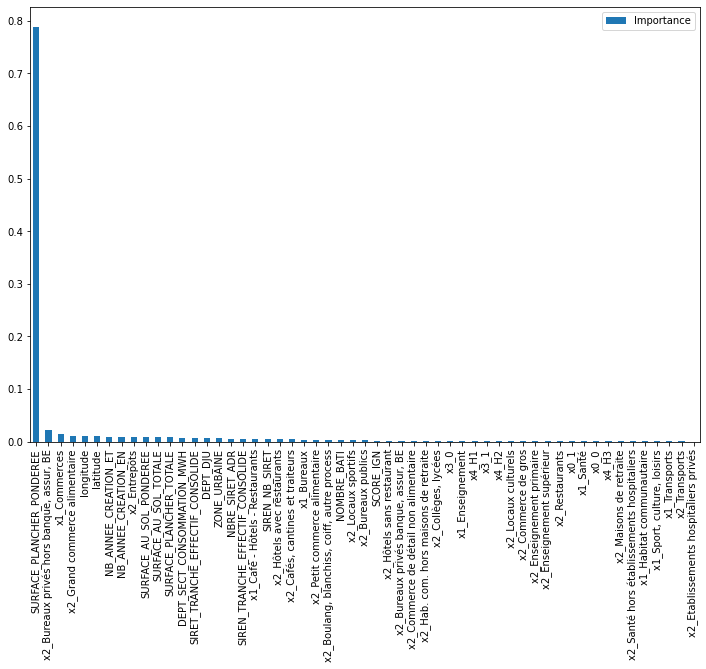

In [19]:
feat_importances = pd.DataFrame(
    rf.feature_importances_, index=feature_cols, columns=["Importance"]
)
feat_importances.sort_values(by="Importance", ascending=False, inplace=True)
feat_importances.plot(kind="bar", figsize=(12, 8))

**Performances :**

In [20]:
from sklearn.metrics import r2_score

In [21]:
r2_score(y_train, y_train_predicted)

0.9820485807322747

In [22]:
r2_score(y_val, y_val_predicted)

0.8687992173790564

En comparant **les deux scores obtenus sur l'ensemble d'apprentissage et l'ensemble de test**, nous remarquons que le modèle **overfitte**.

Afin d'éviter ce phénoméne, nous allons **tuner différents paramètres** de notre modèle en construisant un **GridSearch** dans la section suivante et nous allons comparer les différentes performances. 

#### **Incertitude des prédictions**

Comme le random forest est un modèle d'ensemble d'arbres de décision, pour prédire le résultat d'un point donné, on fait passer le point en question par tous les arbres de décision.

Dans le cas de régression, la prédiction finale du random forest est la moyenne des prédictions des arbres de décision. Pour avoir **une idéee de l'incertitude de la prédiction**, on peut aussi calculer **l'écart-type des prédictions des arbres de décision**.

Dans les lignes de code ci-dessous, on réalise le calcul pour le *premier point du train set*. Le calcul peut très bien être fait pour tous les points du jeu de données.

In [23]:
# On calcule la prédiction de chaque arbre de décision
all_estimators_preds = np.stack(
    [t.predict(X_train.loc[[0]].to_numpy()) for t in rf.estimators_]
)

La moyenne des prédictions des arbres de décision constituant le random forest correspond à la prédiction du random forest.

In [24]:
# Prédiction du random forest
rf.predict(X_train.loc[[0]])

array([1.73960724])

In [25]:
# Moyenne des prédictions
np.mean(all_estimators_preds)

1.7396072406666878

L'écart-type des prédictions peut être calculé ainsi:

In [26]:
np.std(all_estimators_preds)

0.09035933682146148

In [27]:
print(
    f"La prédiction du modèle pour ce point est {rf.predict(X_train.loc[[0]]).item():.3f} ± {np.std(all_estimators_preds):.3f}"
)

La prédiction du modèle pour ce point est 1.740 ± 0.090


Un **intervalle de confiance de la prédiction à 95%**  peut également être calculé.

In [28]:
np.quantile(all_estimators_preds, [0.025, 0.975])

array([1.53623696, 1.89925726])

### **2.3. Implémation via GridSearch**

Cette approche peut se révéler **très performante**, elle consiste à utiliser la recherche par quadrillage. 

Son implémentation est plutôt simple, l'idée est de donner **une liste de valeurs pour chacun des hyper-paramètres** et pour chacune des combinaisons, un modèle sera entraineé, pour conserver à la fin celui avec **le meilleur score**. 

<div class="alert alert-block alert-success"><b>
    NB :</b> D'autres alternatives existent pour tuner les hyperparamètres telles que l'utilisation de la recherche aléatoire d'hyperparamètres `RandomizedSearchCV` ou les méthodes de recherche bayésiennes.</div>

#### **Paramètres à tuner**

Nous retrouvons ci-dessous **une description des paramètres importants** lors de l'entrainement d'un modèle de RandomForest :

- **n_estimators**: Nombre d'abres de décision à entrainer dans le modèle. Dans le cas où l'entrainement se fait sur un grand nombre d'arbres, il permet d'avoir de meilleures performances mais rend l'exécution beaucoup plus lente et augmente le risque d'overfitting.

- **max_features**: Nombre maximal des variables à considèrer lors de chaque split. En limitant le nombre de features pour chaque arbre, ceci pourrait réduire la performance de chaque arbre mais a le grand avantage de produire des arbres décorrélés entre eux. Il est souvent conseillé de prendre la racine carré du nombre de features du dataset.
<br>Si on utilise tous les features et que la liste des variables contient une variable avec un fort pouvoir prédictif, on risque de toujours avoir cette variable au niveau du premier split des arbres, et donc avoir des arbres trop similaires.

- **max_depth**: Profondeur maximale de chaque arbre du modèle. Il correspond au chemin le plus long entre le noeud "root" et le noeud "terminal". Ce paramètre permet de réduire la complexité du modèle, en réduisant ainsi le risque d'overfitting.

- **min_samples_leaf**: Nombre minimal d'échantillons de données requis pour être dans un noeud "terminal". Ce paramètre influence aussi la profondeur max de l'arbre et permet également de réduire le risque d'overfitting. 

- **bootstrap**: [`True` ou `False`] Choix de la stratégie d'échantillonage, avec ou sans remise. Dans le modèle RF, par défaut, l'échantillonage sera effectué avec remise. Si `boostrap` est égal à `False`, toutes les données seront utilisées pour entrainer chaque arbre de décision, il n'y a donc pas de variation aléatoire entre les arbres par rapport aux exemples sélectionnés à chaque étape. Cependant, la forêt aléatoire a une deuxième source de variation, qui est le sous-ensemble aléatoire de variables à considérer lors de chaque split.

- **oob_score**: [`True` ou `False`] Quand bootstrap est égale à `True`, chaque arbre est entrainé sur un échantillon (échantillonage avec remise) des données. Le reste des lignes faisant partie du training set n'est donc pas utilisé lors de l'entrainement par l'arbre. Ces lignes là constituent **l'échantillon Out-of-bag** et peuvent donc être utilisées de manière équivalent à un validation set.
<br>Chaque arbre peut donc être évalué sur son échantillon out-of-bag et le résultat peut être considéré comme un score de validation. Le `oob_score` correspond au score par défaut du modèle sur l'échantillon out-of-bag. Cette mesure est **pratique surtout quand le jeu de données a une taille limitée et le validation set ne peut pas être construit**.
<br>D'autres métriques peuvent être calculées sur l'échantillon out-of-bag en utilisant `oob_prediction_`.

- **n_jobs**: Nombre de CPUs utilisés lors de l'entrainement.

- **random_state**: Choix du facteur aléatoire. Il s'agit du paramètre qui assure que les résultats obtenus soient reproductibles étant donné la nature aléatoire du modèle RF. 

- **verbose**: Permet d'afficher des informations plus « détaillées » pour la tâche executée.




Pour **implémenter le GridSearch** avec Scikit-Learn,  il suffit de créer un dictionnaire Python "param_grid" avec les hyper-paramètres a paramétrer et les valeurs qu'on souhaite tester.

Dans le modèle de random forest, tous les paramètres n'apportent pas un vrai gain de performance. Générelement, il suffit de tuner les paramètres suivants:
- **n_estimators**: Le nombre d'arbres est généralement le paramètre le plus important lors de l'entrainement d'un modèle de random forest. Parfois, il convient de commencer par un test de plusieurs valeurs du nombre d'estimateurs afin de déterminer le nombre d'estimateurs nécessaires pour overfitter. Une fois que ce seuil est déterminé, les paramètres ci-dessous vont permettre de régulariser le modèle.

- **min_samples_leaf**
- **max_depth**
- **max_features**: Quand le nombre d'arbres est grand, la différence entre les deux otpions de scikit-learn, en l'occurrence `log2` et `sqrt` est minime.

**<font color='red'>Remarque:</font>** Parfois, le paramètre `min_impurity_decrease` est utilisé pour régulariser les random forest. `min_impurity_decrease` permet de n'ajouter de split que si le split permet un certain gain de performance. Ceci ne prend pas donc en compte l'interaction entre les variables. Il arrive que le premier split ne soit pas optimal mais que l'ensemble de deux splits consécutifs permette de bien discriminer les données

Dans notre cas, nous allons **entrainer une GridSearch avec 240 combinaisons de paramètres différents**, cela signifie que **nos données seront entrainés sur 120 modèles.**

In [29]:
from sklearn.model_selection import GridSearchCV

# Instantiate GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 300, 500],
    "min_samples_leaf": [1, 5, 10],
    "max_depth": [2, 4, 6, 8, 10],
    "max_features": ["auto", "sqrt"],
}

rf_model = RandomForestRegressor(oob_score=True)

model_gridsearch = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=4,
    refit=True,
    return_train_score=True,
)

Ensuite nous allons **entrainer la classe GridSearchCV** avec la **méthode "fit()"**.

**<font color='red'>Remarque:</font>** Comme on passe par la validation croisée et qu'on a en plus le oob_score, on va créer un nouveau train set qui correspond à l'ancien train set augmenté de la validation set.
Cette démarche n'est pas correcte à 100% vu que le pipeline de transformation de données n'a été entrainé que sur le train set mais ça nous évitera de refaire le pipeline (et donc de gagner du temps😅)

In [30]:
import time

start = time.time()
model_gridsearch.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % ((time.time() - start), len(model_gridsearch.cv_results_["params"]))
)

GridSearchCV took 819.55 seconds for 120 candidate parameter settings.


Une fois le modèle implémenté et entrainé, nous analysons **les performances du modèle sur l'ensemble d'apprentissage ainsi que sur l'ensemble de test** comme suit :

In [31]:
y_train_grid = model_gridsearch.predict(pd.concat([X_train, X_val]))
r2_score(pd.concat([y_train, y_val]), y_train_grid)

0.8884169819343597

On calcule le score OOB qui est équivalent au score de validation. La valeur du score OOB va nous permettre de voir si le modèle overfitte.

In [32]:
model_gridsearch.best_estimator_.oob_score_

0.8621597585405792

On voit que les paramètres issus du grid search ont permis de réduire l'overfitting.

Suite à **l'implémentation du GridSearch**, nous obtenons **le modèle et les hyper-paramètres qui permettent d'avoir une très bonne performance sur nos données.** 

Nous arrivons à avoir **des performances semblables sur l'ensemble d'apprentissage et sur l'ensemble de validation** ce qui nous permet d'éviter le problème d'overfitting survenu au niveau de la première partie du notebook dans l'implémentation du modèle de RandomForest simple en paramètrant uniquement le nombre d'arbres de décisions à entrainer "n_estimators".

Maintenant, on évalue la performance du **modèle retenu** sur le test set pour avoir les performances du modèle.

In [33]:
y_pred_grid = model_gridsearch.predict(X_test)
r2_score(y_test, y_pred_grid)

0.8605156388045487

<hr>
Nous trouverons ci-dessous quelques **propriétés utilses afin d'accèder aux différents éléments du GridSearch** :

La fonction **"cv_results_"** permet d'obtenir **les résultats de la cross validation :**

In [ ]:
print("Best Results:", model_gridsearch.cv_results_)

La fonction **"best_score_"** permet de renvoyer **le meilleur score suite à la cross validation :**

In [35]:
print("Best Score:", model_gridsearch.best_score_)

Best Score: 0.8612346539373587


La fonction **"best_params_"** permet d'obtenir **les hyper-paramètres permettant d'avoir le meilleur score :**

In [36]:
print("Best params:", model_gridsearch.best_params_)

Best params: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}


On voit que le modèle final correspond au modèle avec le minimum de régularisation au niveau de la grille et que le modèle n'overfitte pas

La fonction **"best_estimator_"** permet de stocker **le modèle le plus performant :**

In [37]:
print("Best estimator:", model_gridsearch.best_estimator_)

Best estimator: RandomForestRegressor(max_depth=10, n_estimators=500, oob_score=True)
